In [165]:
import pandas as pd
import os
import zipfile
import glob
from pathlib import Path
import calendar
from datetime import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")

As mentioned during the meeting, the dataset includes phone checks of 10K users in the time between 2016 and 2019. 
 
Each user has been selected with the following inclusion criteria:
-	Active for at least 6 months (a month is here considered as 30 days)
-	Having at least 90% coverage (i.e. being active at least 90% of the days in the time span)
 
The dataset is stored in parquet files (about 3GB accessible via pandas read_parquet function or pyspark) and it is in the form of a dataframe having 3 columns:
-	user_id (int): number between 0-9999 indicating the id of a user;
-	start_time_unix (timestamp): unix timestamp indicating the starting time of a phone check;
-	end_time_unix (timestamp): unix timestamp indicating the ending time of a phone check.

## Reading the data

In [2]:
fileName = 'data_for_AsteriosIlektra'
filePath = os.path.abspath(os.path.join(os.getcwd(), fileName))
data_dir = Path(filePath)

In [3]:
full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
#full_df.to_csv('csv_file.csv')

#### New dataset, user id and how many times have opened their phone generally

In [4]:
users_times_accessed = pd.DataFrame(full_df.groupby(['user_id'])['start_time_unix'].count())

## Making new features

#### Year, month, days (numeric and strings) etc.

In [5]:
full_df['start_time'] = pd.to_datetime(full_df['start_time_unix'], unit='s', origin='unix')
full_df['end_time'] = pd.to_datetime(full_df['end_time_unix'], unit='s', origin='unix')

In [6]:
#pd.to_datetime(full_df['start_time_unix']).dt.year.unique()

In [7]:
full_df['year'] = pd.to_datetime(full_df['start_time']).dt.year
full_df['month'] = pd.to_datetime(full_df['start_time']).dt.month
full_df['weekday'] = pd.to_datetime(full_df['start_time']).dt.weekday # monday is 0
full_df['day'] = pd.to_datetime(full_df['start_time']).dt.day
full_df['Day'] = pd.to_datetime(full_df['start_time']).dt.strftime('%A') #day numeric
full_df['hour'] = pd.to_datetime(full_df['start_time']).dt.hour
full_df['minute'] = pd.to_datetime(full_df['start_time']).dt.minute
full_df['second'] = pd.to_datetime(full_df['start_time']).dt.second

In [65]:
full_df['date'] = pd.to_datetime(full_df['start_time']).dt.date

In [87]:
#full_df

In [9]:
# to right order day strings
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
full_df['Day'] = pd.Categorical(full_df['Day'], categories=cats, ordered=True)

# to change month into month strings
full_df['Month'] = full_df['month'].apply(lambda x: calendar.month_abbr[x])
cats = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec',]
full_df['Month'] = pd.Categorical(full_df['Month'], categories=cats, ordered=True)

#### Duration between sessions

In [10]:
full_df['duration'] = full_df['end_time'] - full_df['start_time']
#full_df['duration_in_seconds'] = full_df['duration'].apply( lambda x: x.seconds)

In [11]:
def days_hours_minutes_seconds(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60, td.seconds


days_hours_minutes_seconds(full_df.iloc[0]['duration'])

(0, 0, 0, 54)

## Plots

#### Plotting the distribution of acticity of the different users that contributed in the database

In [133]:
dates = full_df.groupby('user_id').agg({'date': ['min', 'max']})
dates['Duration'] = dates[('date', 'max')] - dates[('date', 'min')]

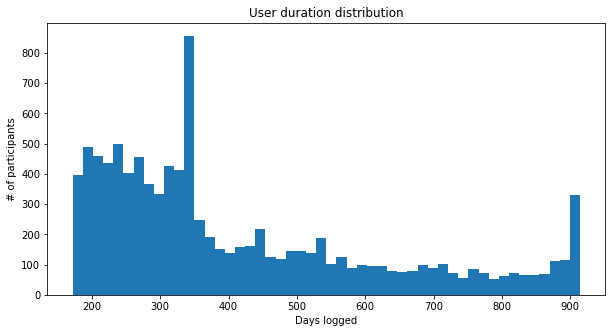

In [134]:
plt.figure(figsize=(10,5))
plt.hist(dates['Duration'].apply( lambda x: x.days), bins=50)
plt.title('User duration distribution')
plt.xlabel('Days logged')
plt.ylabel('# of participants')
plt.show()

#### Plotting (summed up) session duration of the weekdays

In [135]:
weekly_overall_duration = full_df.groupby(['Day'])['duration'].sum()

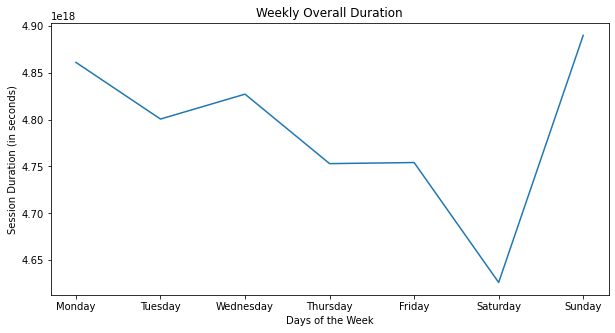

In [136]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,5))
plt.plot(weekly_overall_duration)
plt.title('Weekly Overall Duration')
plt.xlabel('Days of the Week')
plt.ylabel('Session Duration (in seconds)')
plt.show()

#### Summed up session duration in Months

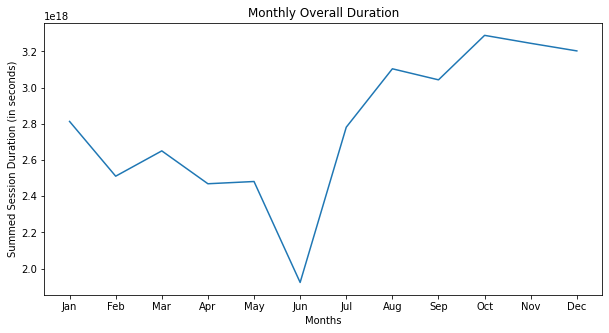

In [138]:
monthly_overall_duration = full_df.groupby(['Month'])['duration'].sum()

plt.figure(figsize=(10,5))
plt.plot(monthly_overall_duration)
plt.title('Monthly Overall Duration')
plt.xlabel('Months')
plt.ylabel('Summed Session Duration (in seconds)')
plt.show()

#### And a weird bug.. trying to find the session duration across years

In [139]:
#test = full_df[(full_df['year'] == 2017) | (full_df['year'] == 2018)]

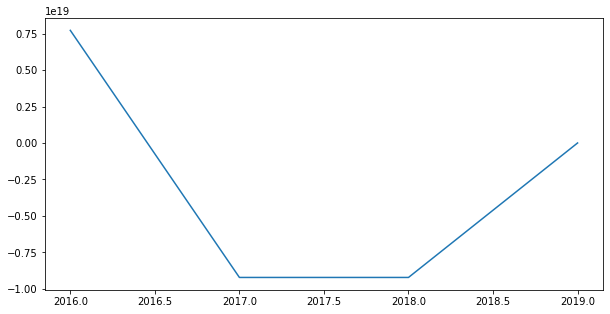

In [140]:
yearly_overall_duration = full_df.groupby('year')['duration'].sum()

plt.figure(figsize=(10,5))
plt.plot(yearly_overall_duration)
plt.show()

In [141]:
yearly_overall_duration

year
2016   89386 days 20:50:28
2017                   NaT
2018                   NaT
2019       0 days 03:32:13
Name: duration, dtype: timedelta64[ns]

#### Hourly summed session duration

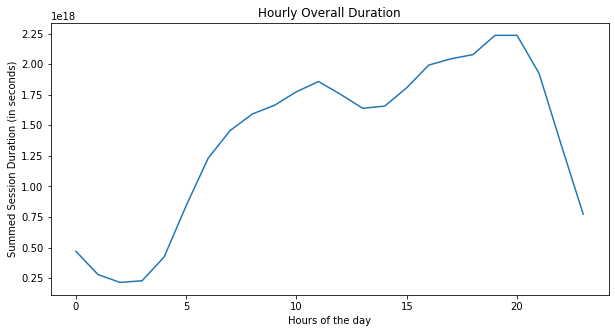

In [142]:
hourly_overall_duration = full_df.groupby(['hour'])['duration'].sum()

plt.figure(figsize=(10,5))
plt.plot(hourly_overall_duration)
plt.title('Hourly Overall Duration')
plt.xlabel('Hours of the day')
plt.ylabel('Summed Session Duration (in seconds)')
plt.show()

#### Yearly number of sessions (log counts)

In [144]:
yearly_logs = full_df.groupby(['year'])['user_id'].count()

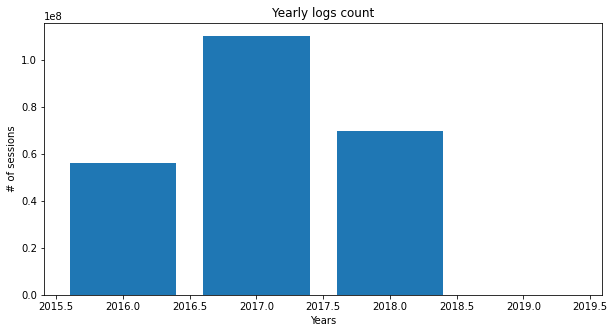

In [145]:
plt.figure(figsize=(10,5))
plt.title('Yearly logs count')
plt.xlabel('Years')
plt.ylabel('# of sessions')
plt.bar(yearly_logs.index, yearly_logs.values)
plt.show()

#### Activity duration distribution 

In [146]:
duration_in_seconds = full_df['duration'].apply(lambda x : x.seconds)

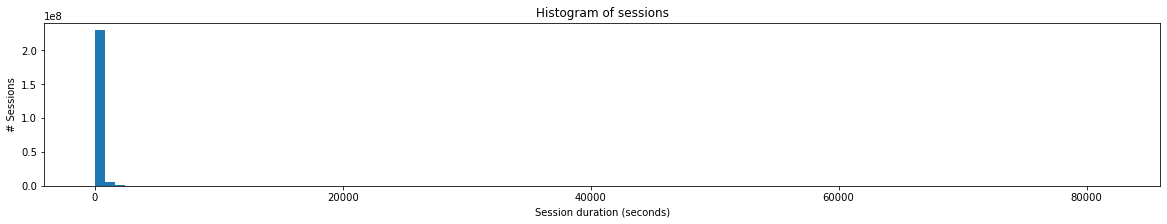

In [176]:
plt.figure(figsize=(20,3))
plt.hist(duration_in_seconds, bins=100)
plt.title('Histogram of sessions')
plt.xlabel('Session duration (seconds)')
plt.ylabel('# Sessions')
plt.show()

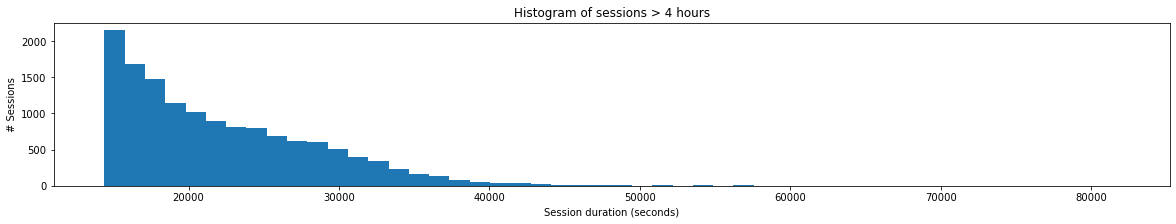

In [177]:
minutes = 240 *60

plt.figure(figsize=(20,3))
plt.hist(duration_in_seconds[duration_in_seconds > minutes], bins=50)
plt.title('Histogram of sessions > 4 hours')
plt.xlabel('Session duration (seconds)')
plt.ylabel('# Sessions')
plt.show()

#### Month Coverage by counts of activities

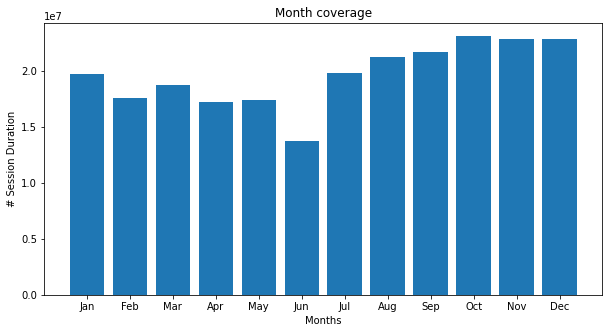

In [149]:
monthly_bar_duration = full_df.groupby(['Month'])['duration'].count()

plt.figure(figsize=(10,5))
plt.bar(monthly_bar_duration.index, monthly_bar_duration.values)
plt.title('Month coverage')
plt.xlabel('Months')
plt.ylabel('# Session Duration')
plt.show()

In [158]:
user_log_counts = full_df.groupby(['user_id'])['duration'].count()

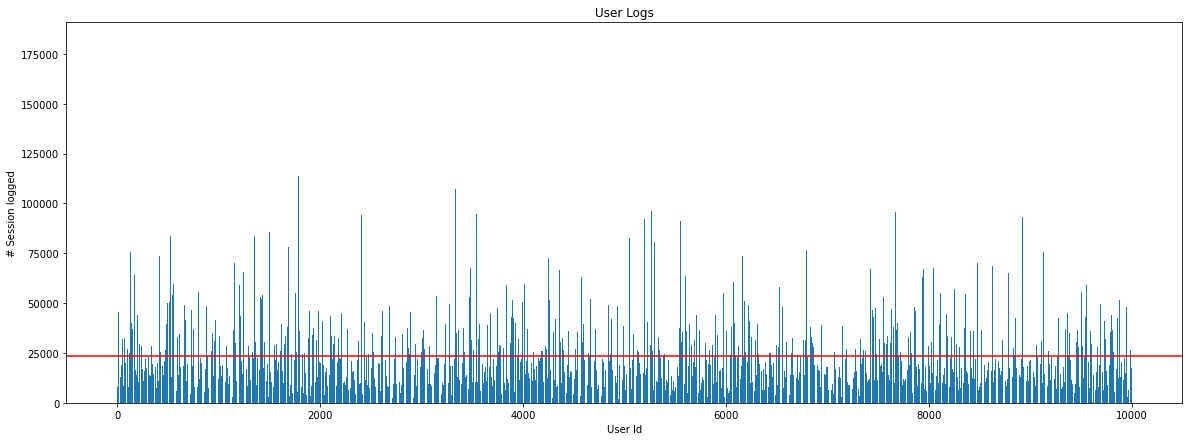

In [173]:
plt.figure(figsize=(20,7))
plt.bar(user_log_counts.index, user_log_counts.values)
plt.axhline(np.mean(user_log_counts), color='r')
plt.title('User Logs')
plt.xlabel('User Id')
plt.ylabel('# Session logged')
plt.show()

In [167]:
np.mean(user_log_counts)

23623.1168

### For a specific user (eg 1)

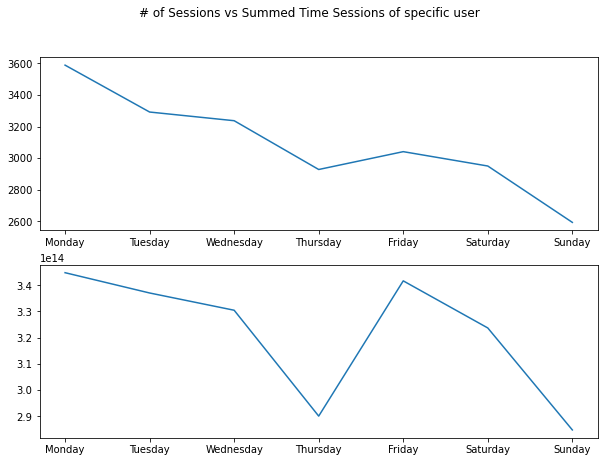

In [186]:
fig, axs = plt.subplots(2, figsize=(10,7))
fig.suptitle('# of Sessions vs Summed Time Sessions of specific user')
axs[0].plot(full_df[full_df['user_id'] == 1].groupby(['Day'])['duration'].count())
axs[1].plot(full_df[full_df['user_id'] == 1].groupby(['Day'])['duration'].sum())
plt.show()

In [150]:
user1_days = full_df[full_df['user_id'] == 1].groupby(['day'])['duration'].sum()

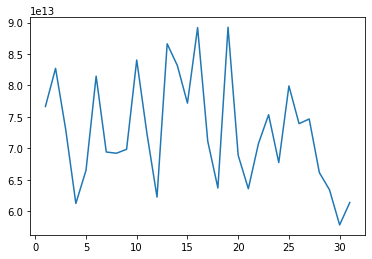

In [151]:
plt.plot(user1_days)
plt.show()

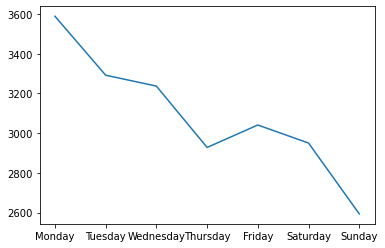

In [152]:
plt.plot(full_df[full_df['user_id'] == 1].groupby(['Day'])['duration'].count())
plt.show()

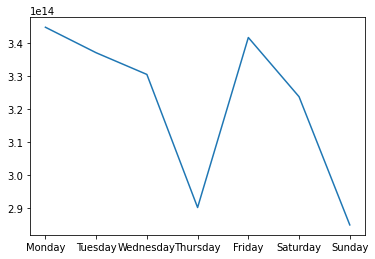

In [153]:
plt.plot(full_df[full_df['user_id'] == 1].groupby(['Day'])['duration'].sum())
plt.show()

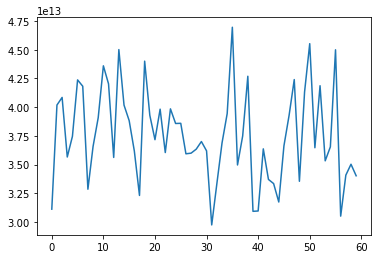

In [154]:
plt.plot(full_df[full_df['user_id'] == 1].groupby(['minute'])['duration'].sum())
plt.show()

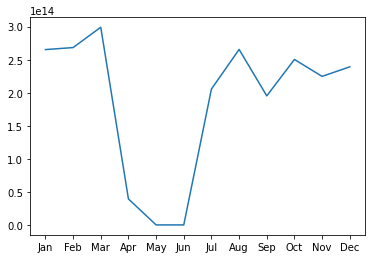

In [155]:
plt.plot(full_df[full_df['user_id'] == 1].groupby(['Month'])['duration'].sum())
plt.show()

In [156]:
pd.DataFrame(full_df[full_df['user_id'] == 4].groupby(['Month'])['duration'].count())

,duration
Month,
Jan,1089
Feb,860
Mar,774
Apr,1177
May,1400
Jun,274
Jul,0
Aug,578
Sep,1510
